# Project Goal
## Bussiness Object
* Build Predictive maintenance models to predict the probability of device failure based on a year’s worth of data, Which can help determine wheather or not a maintenance should be performed to the in-service equipment.
## Technical Object
* The target model should minimize false positives(specificity) and false negatives(sensitivity) as much as possible.
* Find out how to deal with imbalanced dataset.

In [ ]:
pd.DataFrame()

# Data exploration

## Import moduels

In [1]:
#import moduels
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
#from sklearn.naive_bayes import GaussianNB
#from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import GradientBoostingClassifier
#from xgboost import XGBClassifier
#xgb=XGBClassifier()
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import ExtraTreesClassifier
#from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
from xgboost import XGBClassifier
import pandas_profiling

import pandas as pd
from datetime import datetime
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, precision_score
#import xgboost as xgb

from sklearn.model_selection import StratifiedKFold
from imblearn.metrics import geometric_mean_score as geo
from imblearn.metrics import make_index_balanced_accuracy as iba
from sklearn.metrics import roc_curve, auc
from imblearn.metrics import geometric_mean_score, make_index_balanced_accuracy, classification_report_imbalanced

## Load data as dataframe and data overview

In [2]:
df = pd.read_csv('failures_prediction.csv')

In [3]:
df.head()

date    device  failure  attribute1  attribute2  attribute3  \
0  2015-01-01  S1F01085        0   215630672          56           0   
1  2015-01-01  S1F0166B        0    61370680           0           3   
2  2015-01-01  S1F01E6Y        0   173295968           0           0   
3  2015-01-01  S1F01JE0        0    79694024           0           0   
4  2015-01-01  S1F01R2B        0   135970480           0           0   

   attribute4  attribute5  attribute6  attribute7  attribute8  attribute9  
0          52           6      407438           0           0           7  
1           0           6      403174           0           0           0  
2           0          12      237394           0           0           0  
3           0           6      410186           0           0           0  
4           0          15      313173           0           0           3

In [4]:
pandas_profiling.ProfileReport(df)

Summarize dataset:   0%|          | 0/25 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
#no missing values
df.isnull().sum()

date          0
device        0
failure       0
attribute1    0
attribute2    0
attribute3    0
attribute4    0
attribute5    0
attribute6    0
attribute7    0
attribute8    0
attribute9    0
dtype: int64

In [6]:
#imbalanced classification problem
df.failure.value_counts()

0    124388
1       106
Name: failure, dtype: int64

In [7]:
#no duplicated observations
df.duplicated().sum()

#output number of unique values for each column,
#7 attributes have very high percentage of zero values. 
#These could be error codes or some other indicator, I will change their data types later.
#cols = df.columns
#for col in cols:
#    print(col)
#    print(df[col].nunique())
#
#df.columns

0

In [8]:
df.nunique()

date             304
device          1168
failure            2
attribute1    123878
attribute2       558
attribute3        47
attribute4       115
attribute5        60
attribute6     44838
attribute7        28
attribute8        28
attribute9        65
dtype: int64

## Summary
* This dataset is clean, no missing values. All attributes are integer data type.
* It is imbalanced data set, as the failuer class is about 0.1% of unfailure class.Here oversampling approach is used to deal with imbalanced dataset.
* Some attributes have limited number of distictive values, very sparse, indicating that they are likely to be categorical variable, such as attibute 3, 5,7,9.
* Attribute7 and 8 seems like exactly same to each other, we can drop one of them.
* Attribute 2,3,4,7,9 are highly skewed.
* Attributes differ in their magnitudes. Scaling or centering is requried.

# Data Engineering

## 'Date' exploration

### Create features based on date

In [9]:
# create three more features based on date.
df.date = pd.to_datetime(df.date)

df['activedays']=df.date-df.date[0]

df['month']=df['date'].dt.month
df['week_day']=df.date.dt.weekday
df['week_day'].replace(0,7,inplace=True)
df.head()

date    device  failure  attribute1  attribute2  attribute3  \
0 2015-01-01  S1F01085        0   215630672          56           0   
1 2015-01-01  S1F0166B        0    61370680           0           3   
2 2015-01-01  S1F01E6Y        0   173295968           0           0   
3 2015-01-01  S1F01JE0        0    79694024           0           0   
4 2015-01-01  S1F01R2B        0   135970480           0           0   

   attribute4  attribute5  attribute6  attribute7  attribute8  attribute9  \
0          52           6      407438           0           0           7   
1           0           6      403174           0           0           0   
2           0          12      237394           0           0           0   
3           0           6      410186           0           0           0   
4           0          15      313173           0           0           3   

  activedays  month  week_day  
0     0 days      1         3  
1     0 days      1         3  
2     0 days      1         3  
3     0 days      1         3  
4     0 days      1         3

In [ ]:
#season = []
#for dt in df.date:
#    if dt < datetime(2015,3,1):
#        season.append('winter')
#    elif dt < datetime(2015,6,1):
#        season.append('spring')
#    elif dt<datetime(2015,9,1):
#        season.append('summer')
#    else:
#        season.append('fall')
#        
#df['season']=season
#df.head()

In [11]:
df.groupby('month').agg({'device':lambda x: x.nunique()})

device
month        
1        1164
2         726
3         685
4         491
5         424
6         352
7         346
8         334
9         184
10        146
11         31

### Data visualization in Date

<AxesSubplot:xlabel='month'>

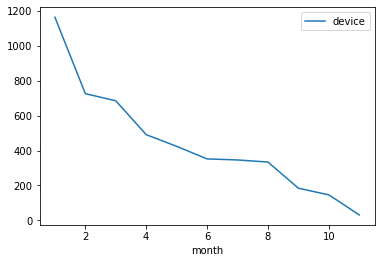

In [12]:
df.groupby('month').agg({'device':lambda x: x.nunique()}).plot()

This figure shows that as time move on, the number of devices are getting less and less.

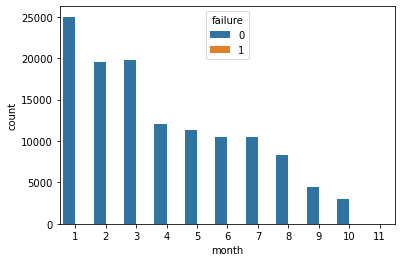

In [13]:
ax = sns.countplot(x="month", hue="failure", data=df)

This figure shows most of the devices failed in the first month.

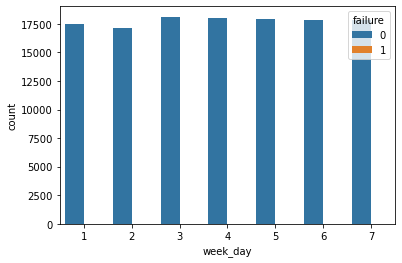

In [14]:
ax = sns.countplot(x='week_day',hue='failure',data=df)

This figure shows that there is no device fails on Friday and Saturday. Maybe they don't work on the two days.

In [ ]:
df.groupby('activedays')['device'].count().plot()

 One can see that the number of devices decreases as time goes by. And there is a big jump in the middle of activedays. Those may be some devices got put back in after they failed and fixed well. We will investigate the detail later.

In [ ]:
#df.info()
#
#q=df.groupby('device')['failure'].mean()
#
#q=q.to_dict()
#q
#
#df['failure_rate']=df['device'].map(q)
#
#df.head()

In [ ]:
max(df.date), min(df.date)

All of these data are collected between 11/02/2015 and 01/01/2015

### Devices come back to use

In [ ]:
df_date = df.groupby('device').agg({'date':max})

df_date.date.to_dict()

df_failure = df.loc[df.failure==1,['device','date']]


df_good = df.loc[df.failure==0,['device','date']]

df_date.shape,df_failure.shape

df['max_date']=df.device.map(df_date.date.to_dict())

df.head()

#dfa = df[~df.device.isin(df_failure.device)]

dff=df[(df.failure==1)&(df.date!=df.max_date)]
dff

Max date means the last day the device got checked. If the max day is ahead of failure date, it means this device returned to use after failed because got fixed.

In [ ]:
fig = plt.figure(figsize=(15,5))
fig.add_subplot(3, 2, 1) 
plt.plot(df.loc[df['device']=='S1F136J0',['failure','month']]['month'],df.loc[df['device']=='S1F136J0',\
         ['failure','month']]['failure'],\
         color = 'red')
fig.add_subplot(3, 2, 2) 
plt.plot(df.loc[df['device']=='W1F0KCP2',['failure','month']]['month'],df.loc[df['device']=='W1F0KCP2',\
         ['failure','month']]['failure'],\
         color = 'red')
fig.add_subplot(3, 2, 3)
plt.plot(df.loc[df['device']=='W1F0M35B',['failure','month']]['month'],df.loc[df['device']=='W1F0M35B',\
         ['failure','month']]['failure'],\
         color = 'red')
fig.add_subplot(3, 2, 4)
plt.plot(df.loc[df['device']=='S1F0GPFZ',['failure','month']]['month'],df.loc[df['device']=='S1F0GPFZ',\
         ['failure','month']]['failure'],\
         color = 'red')
fig.add_subplot(3, 2, 5)
plt.plot(df.loc[df['device']=='W1F11ZG9',['failure','month']]['month'],df.loc[df['device']=='W1F11ZG9',\
         ['failure','month']]['failure'],\
         color = 'red')

plt.show()

In [ ]:
df[df.device == 'S1F136J0']

In [ ]:
#for col in ['attribute1', 'attribute2', 'attribute3',
#       'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute8',
#       'attribute9']:
#sns.lmplot(x='attribute1',y='failure',data=df,logistic=True,y_jitter=.03)

## Reduce data set with unique device id

In [ ]:
df.attribute1.nunique()

In [ ]:
# Here I just keep the last record, as it comes with the most usefull infomation.
df1 = df.groupby('device').agg({'date':max})

In [ ]:
df1.shape

In [ ]:
df1=df1.reset_index()

df=df.reset_index(drop=True) 

df2= pd.merge(df1,df,how='left',on=['device','date'])

df2.shape


In [ ]:
df2.tail()

### Create  feature called  'failure_before' 

If we just take the last record for the devices, we may lose information from those come back after failed ones

In [ ]:
df2['failure_before']=0

In [ ]:
df2.loc[df2.device == 'S1F136J0','failure_before'] = 1
df2.loc[df2.device == 'W1F0KCP2','failure_before'] = 1
df2.loc[df2.device == 'W1F0M35B','failure_before'] = 1
df2.loc[df2.device == 'S1F0GPFZ','failure_before'] = 1
df2.loc[df2.device == 'W1F11ZG9','failure_before'] = 1

## Redefine device Id value

In [ ]:
df2.device

In [ ]:
Id = df2.device.values.tolist()

In [ ]:
#change device id values to the first four characters
Id1 = [] 
for i in Id:
    i = i[:4]
    Id1.append(i)

df2.device=Id1

df2.device.value_counts()

In [ ]:
dev=pd.crosstab(df2['device'],df2['failure']) 

In [ ]:
dev.div(dev.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True) 

Devices ID begins with ZIF0 fails the most, then W1F1 second

## Data transformation

### Redefing data types

In [ ]:

#redefine data type for some of the numerical features
cat_ftrs = ['attribute3','attribute4', 'attribute5', 'attribute7', 'attribute9'] 
for col in cat_ftrs:
    df2[col]=df2[col].astype('object')

In [ ]:
# change activedays datatype to numerical
def str_to_num(str):
    return str.split(' ')[0]

df2.info()

In [ ]:
df2.activedays = df2.activedays.astype('str')

df2.activedays=df2.activedays.apply(str_to_num)
df2.activedays = df2.activedays.astype('int')
df2.info()

In [ ]:
for col in ['month','week_day']:
    df2[col]=df2[col].astype('object')

### Data standarlization

In [ ]:
#numerical features normalization
f, axarr = plt.subplots(1,2) 
sns.distplot(df2['attribute1'],ax=axarr[0]) 
axarr[0].set_title('Skewed Distribution') 
sns.distplot(np.log(1+df2['attribute1']),ax=axarr[1]) 
axarr[1].set_title('Log-Transformed Distribution')

In [ ]:
f, axarr = plt.subplots(1,2) 

sns.distplot(df2['attribute2'],ax=axarr[0]) 
axarr[0].set_title('Skewed Distribution') 
sns.distplot(np.log(1+df2['attribute2']),ax=axarr[1]) 
axarr[1].set_title('Log-Transformed Distribution')

In [ ]:
f, axarr = plt.subplots(1,2) 
sns.distplot(df2['attribute6'],ax=axarr[0]) 
axarr[0].set_title('Skewed Distribution') 
sns.distplot(np.log(1+df2['attribute6']),ax=axarr[1]) 
axarr[1].set_title('Log-Transformed Distribution')

It seems the data get more skewed after log, so I'd rather not take log on them.

In [ ]:
#numerical features standardization
num_ftrs =['attribute1','attribute2','attribute6'] 
df2[num_ftrs]=scaler.fit_transform(df2[num_ftrs])

df2.info()

## Drop unimportant and redundant features 

In [ ]:
sns.pairplot(df)

It is obvious that attribute7 and attribut8 is highly linear related or equal to each other

In [ ]:
(df['attribute7']==df['attribute8']).value_counts()

In [ ]:
# then I drop attribute 8, as it is duplicated.
df.drop('attribute8',axis=1,inplace=True)

In [ ]:
df.head()

In [ ]:
df2.drop(['date','max_date'],axis=1,inplace=True)

In [ ]:
df2.info()

## get dummies on categorical feature

In [ ]:
df2.head()

In [ ]:
df2 = pd.get_dummies(df2,drop_first=True)

In [ ]:
df2.shape

In [ ]:
df2.failure.value_counts()

# Feature Selection

## Define dependent and independent values

In [ ]:
X = df2.drop('failure',axis=1)
Y = df2.failure

## Feature Selection

In [ ]:
clf = RandomForestClassifier(n_estimators=50, max_features='auto')
clf= clf.fit(X,Y)

features = pd.DataFrame()
features['feature']= X.columns
features['important']=clf.feature_importances_
features.sort_values(by=['important'], ascending=False,inplace=True)
features.set_index('feature', inplace=True)
features.iloc[:20,:].plot(kind='barh', figsize=(30,30))

In [ ]:
model = SelectFromModel(clf,prefit=True)
x_reduced = model.transform(X)
print (x_reduced.shape)


In [ ]:
type(x_reduced)

In [ ]:
x_reduced=pd.DataFrame(x_reduced)

In [ ]:
x_reduced.head()

In [ ]:
x_reduced.info()

# Resample data-test
when encounter with imbalanced dataset, we always re-sample the data in order to mitigate the effect caused by class imbalance. The two most common techniques are over-sampling and under-sampling. Here I used under-sampling as the dataset is little big.

In [ ]:
# import model for imbalanced data set
from imblearn.over_sampling import RandomOverSampler
from imblearn.metrics import geometric_mean_score, make_index_balanced_accuracy, classification_report_imbalanced
from sklearn.metrics import confusion_matrix

In [ ]:
# tested on RandomForestClassifier
X_train, X_test, y_train, y_test = train_test_split(x_reduced, Y, train_size=0.8, \
                                                    random_state=42)


rus = RandomOverSampler(random_state=42)
#With my training data craeated, I'll upsample the failed devices using the RandomOverSampler. This method object to over-sample the minority class(es) by picking samples at random with replacement.

X_res, y_res = rus.fit_sample(X_train, y_train)
X_res.shape

X_res = pd.DataFrame(X_res)
#After upsampling, I'll build a random forest model to classify the failed devices.

rf = RandomForestClassifier(n_estimators=5000, random_state=21)

a = rf.fit(X_res,y_res)



rf_test_pred = rf.predict(X_test)
rf_test_cm = confusion_matrix(y_test, rf_test_pred)
rf_test_cm

accuracy_score(y_test, rf_test_pred)

print(classification_report_imbalanced(y_test,rf_test_pred))

* pre is precision, which is a measure of result relevancy;
* rec is recall, which is the same as sensitivity. Recall is a measure of how many truly relevant results are returned;
* spe is specificity;
* f1 is the harmonic average of the precision and recall;
* geo(Matthews correlation coefficient) is the geometric mean of specificity and sensitivity;
* iba is the index of imbalanced accuracy

# Model Training

## Oversample before cross validate

In [ ]:
log=LogisticRegression()
k=KNeighborsClassifier()
gbc =GradientBoostingClassifier()
rgr = RandomForestRegressor(n_estimators=100)
svc = SVC()
rfc = RandomForestClassifier(n_estimators=10)
xg_reg = XGBClassifier(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,\
                    hidden_layer_sizes=(5, 2), random_state=1)
algorithms=[k,log,gbc,rgr,svc,rfc,xg_reg,clf]
names=['KNeighborsClassifier','Logistic','GradientBoost','RandomForest','SVC','RandomForestCl','xgboost','neunet']

In [ ]:
#i=1
#kf = StratifiedKFold(n_splits=5,random_state=1,shuffle=True) 
#accuracy = []
#for train_index,test_index in kf.split(x_reduced,Y):     
#    print('\n{} of kfold {}'.format(i,kf.n_splits))     
#    xtr,xvl = x_reduced.loc[train_index],x_reduced.loc[test_index]     
#    ytr,yvl = Y[train_index],Y[test_index]         
#    model = LogisticRegression(random_state=1)     
#    model.fit(xtr, ytr)     
#    pred_test = model.predict(xvl)     
#    score = accuracy_score(yvl,pred_test)
#    accuracy.append(score)
#    print('accuracy_score',score)     
#    i+=1 
#print(np.mean(accuracy))

In [ ]:
#from sklearn.model_selection import StratifiedKFold
#
#def cross_validation_fit_predict(x_reduced,Y,algorithms = algorithms, names = names):
#    # fit the data
#    # print metrics
#    Accuracy = []
#    F1 = []
#    Precison =[]
#    Recall =[]
#    for i in range(len(algorithms)):
#        j=1
#        kf = StratifiedKFold(n_splits=5,random_state=1,shuffle=True) 
#        accuracy = []
#        f1 = [] 
#        precision=[]
#        recall = []
#        for train_index,test_index in kf.split(x_reduced,Y):
#            '\n{} of kfold {}'.format(j,kf.n_splits)
#            xtr,xvl = x_reduced.loc[train_index],x_reduced.loc[test_index]     
#            ytr,yvl = Y[train_index],Y[test_index]         
#            algorithms[i] = algorithms[i].fit(xtr, ytr)  
#            pred_test = algorithms[i].predict(xvl)     
#            score = accuracy_score(yvl,pred_test.round())
#            f1_val = f1_score(yvl,pred_test.round())
#            Prec = precision_score(yvl,pred_test.round())
#            rc = recall_score(yvl,pred_test.round())
#            accuracy.append(score)
#            f1.append(f1_val)
#            precision.append(Prec)
#            recall.append(rc)
#            j+=1
#        mean_score = np.mean(accuracy)
#        mean_f1 = np.mean(f1)
#        mean_pre=np.mean(precision)
#        mean_recall=np.mean(recall)
#        Accuracy.append(mean_score)
#        F1.append(mean_f1)
#        Precision.append(mean_pre)
#        Recall.append(mean_recall)
#    metrics = pd.DataFrame(columns = ['Accuracy', 'F1','Precision','Recall'], index = names)
#    metrics['F1'] = F1
#    metrics['Accuracy'] = Accuracy
#    metrics['Precision']=Precision
#    metrics['Recall']=Recall
#    return metrics.sort_values('Accuracy', ascending = False)

here is the link, why I choose geo and iba
https://imbalanced-learn.readthedocs.io/en/stable/auto_examples/evaluation/plot_metrics.html#sphx-glr-auto-examples-evaluation-plot-metrics-py

In [ ]:
iba = make_index_balanced_accuracy(alpha=0.1, squared=True)(geo)

In [ ]:
def cross_vali_fit_pred_1(X_res, y_res, algorithms = algorithms, names = names):
    # fit the data
    #x_train_reduced, x_test_reduced, y_train, y_test = train_test_split(x_reduced,Y,test_size=0.1, random_state=13)
    X_res = X_res.as_matrix()
    Geo_score = []
    Iba_score = []
    Accuracy = []
    F1 = []
    Recall = []
    Prec = []
    for i in range(len(algorithms)):
        j=1
        kf = StratifiedKFold(n_splits=5,random_state=1,shuffle=True)
        geo_score = []
        iba_score = []
        accuracy = []
        f1 = []
        recall = []
        prec = []
        for train_index,test_index in kf.split(X_res,y_res):
            xtr,xvd=X_res[train_index],X_res[test_index]
            ytr,yvd=y_res[train_index],y_res[test_index]
            algorithms[i] = algorithms[i].fit(xtr,ytr)
            y_pred_test = algorithms[i].predict(xvd).round()
            accuracy.append(accuracy_score(yvd, y_pred_test))
            geo_score.append(geo(yvd, y_pred_test))
            iba_score.append(iba(yvd, y_pred_test))
            f1.append(f1_score(yvd, y_pred_test,average='macro'))
            recall.append(recall_score(yvd, y_pred_test,average='macro'))
            prec.append(precision_score(yvd, y_pred_test))
            j +=1
        mean_ac = np.mean(accuracy)
        mean_geo = np.mean(geo_score)
        mean_f1 = np.mean(f1)
        mean_iba = np.mean(iba_score)
        mean_recall = np.mean(recall)
        mean_prec = np.mean(prec)
        F1.append(mean_f1)
        Geo_score.append(mean_geo)
        Iba_score.append(mean_iba)
        Accuracy.append(mean_ac)
        Recall.append(mean_recall)
        Prec.append(mean_prec)
        #cm=confusion_matrix(y_test,y_test_pred)
        #print(cm)
    metrics = pd.DataFrame(columns = ['Accuracy','geo_score','iba_score','f1','recall','prec'],index=names)
    metrics['Accuracy']=Accuracy
    metrics['geo_score']=Geo_score
    metrics['iba_score']=Iba_score
    metrics['f1']=F1
    metrics['recall']=Recall
    metrics['prec'] =Prec
    return metrics.sort_values('geo_score',ascending=False)

In [ ]:
cross_vali_fit_pred_1(X_res, y_res, algorithms = algorithms, names = names)

In [ ]:
RandomForestClassifier().get_params()

In [ ]:
geo(y_test, clf.predict(X_test).round())

In [ ]:
gbc.get_params()

In [ ]:
geo(y_test, gbc.predict(X_test).round())

In [ ]:
k.get_params()

In [ ]:
geo(y_test, k.predict(X_test).round())

The results are too good to be true

### What happened?

    To see how this works, think about how randomoversampler works. If I upsample a dataset before splitting it into a train and validation set, I could end up with the same observation in both datasets. As a result, a complex enough model will be able to perfectly prdict the value for those observations when prediction on the validation set, inflating the metrix.

## Oversample within cross validation

Now I am gonna oversamle on only the training set. In this way the validation data will not have the same observations as in training set.

In [ ]:
def cross_vali_fit_pred_2(X_train, y_train, algorithms = algorithms, names = names):
    # fit the data
    #x_train_reduced, x_test_reduced, y_train, y_test = train_test_split(x_reduced,Y,test_size=0.1, random_state=13)
    #X_test=X_test.as_matrix()
    X_train = X_train.as_matrix()
    y_train = y_train.as_matrix()

    #y_test=y_test.as_matrix()
    Geo_score = []
    Iba_score = []
    Accuracy = []
    F1 = []
    Recall = []
    Prec = []
    for i in range(len(algorithms)):
        j=1
        kf = StratifiedKFold(n_splits=5,random_state=1,shuffle=True)
        geo_score = []
        iba_score = []
        accuracy = []
        f1 = []
        recall = []
        prec = []
        for train_index,test_index in kf.split(X_train, y_train):
            xtr,xvd=X_train[train_index],X_train[test_index]
            ytr,yvd=y_train[train_index],y_train[test_index]
            xtr_res,ytr_res=rus.fit_sample(xtr, ytr)
            algorithms[i] = algorithms[i].fit(xtr_res,ytr_res)
            y_pred_test = algorithms[i].predict(xvd).round()
            accuracy.append(accuracy_score(yvd, y_pred_test))
            geo_score.append(geo(yvd, y_pred_test))
            iba_score.append(iba(yvd, y_pred_test))
            f1.append(f1_score(yvd, y_pred_test,average='macro'))
            recall.append(recall_score(yvd, y_pred_test,average='macro'))
            prec.append(precision_score(yvd, y_pred_test))
            j +=1
        mean_ac = np.mean(accuracy)
        mean_geo = np.mean(geo_score)
        mean_f1 = np.mean(f1)
        mean_iba = np.mean(iba_score)
        mean_recall = np.mean(recall)
        mean_prec = np.mean(prec)
        F1.append(mean_f1)
        Geo_score.append(mean_geo)
        Iba_score.append(mean_iba)
        Accuracy.append(mean_ac)
        Recall.append(mean_recall)
        Prec.append(mean_prec)
        #cm=confusion_matrix(y_test,y_test_pred)
        #print(cm)
    metrics = pd.DataFrame(columns = ['Accuracy','geo_score','iba_score','f1','recall','prec'],index=names)
    metrics['Accuracy']=Accuracy
    metrics['geo_score']=Geo_score
    metrics['iba_score']=Iba_score
    metrics['f1']=F1
    metrics['recall']=Recall
    metrics['prec']=Prec
    return metrics.sort_values('geo_score',ascending=False)

In [ ]:
type(X_train), type(y_train)

In [ ]:
#X_train = X_train.as_matrix()

In [ ]:
#y_train = y_train.as_matrix()

In [ ]:
cross_vali_fit_pred_2(X_train, y_train, algorithms = algorithms, names = names)

## Model evaluation

In [ ]:
X_test=X_test.as_matrix()

y_test=y_test.as_matrix()
probs1 = k.predict_proba(X_test)
probs2 = xg_reg.predict_proba(X_test)
probs3 = gbc.predict_proba(X_test)
probs4 = rfc.predict_proba(X_test)
probs1 = probs1[:,1]
probs2 = probs2[:,1]
probs3 = probs3[:,1]
probs4 = probs4[:,1]

In [ ]:
fpr1, tpr1, thresholds1 = roc_curve(y_test, probs1)
fpr2, tpr2, thresholds2 = roc_curve(y_test, probs2)
fpr3, tpr3, thresholds3 = roc_curve(y_test, probs3)
fpr4, tpr4, thresholds4 = roc_curve(y_test, probs4)
roc_auc1 = auc(fpr1, tpr1)
roc_auc2 = auc(fpr2, tpr2)
roc_auc3 = auc(fpr3, tpr3)
roc_auc4 = auc(fpr4, tpr4)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr1, tpr1, marker='.', markerfacecolor='r',label='Kneighbor (area = %0.2f)' % roc_auc1)
plt.plot(fpr2, tpr2, marker='.', markerfacecolor='g',label='xgboost (area = %0.2f)' % roc_auc2)
plt.plot(fpr3, tpr3, marker='.', markerfacecolor='b',label='gradientboost (area = %0.2f)' % roc_auc3)
plt.plot(fpr4, tpr4, marker='.',markerfacecolor='y',label='randomforestclassifier (area = %0.2f)' % roc_auc4)
plt.xlabel('False Positive Rate(1-Specificity)')
plt.ylabel('True Positive Rate(Sensitivity)')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
geo(y_test, k.predict(X_test).round())

In [ ]:
geo(y_test, gbc.predict(X_test).round())

In [ ]:
geo(y_test, svc.predict(X_test).round())

In [ ]:
geo(y_test, clf.predict(X_test).round())#neutral network result is 0?

In [ ]:
geo(y_test, xg_reg.predict(X_test).round())

In [ ]:
geo(y_test, rfc.predict(X_test).round())

## Model tunning

In [ ]:
X_train = X_train.as_matrix()
y_train = y_train.as_matrix()


In [ ]:
Geo1=[]
Geo2=[]
estimators = [i for i in range(5,150,10)]
Learning_rate = [i for i in np.arange(0.05,0.4,0.03)]
geo_score = []
kf = StratifiedKFold(n_splits=5,random_state=1,shuffle=True)
for i in estimators:
    for train_index,test_index in kf.split(X_train, y_train):
        xtr,xvd=X_train[train_index],X_train[test_index]
        ytr,yvd=y_train[train_index],y_train[test_index]
        xtr_res,ytr_res=rus.fit_sample(xtr, ytr)
        gbc =GradientBoostingClassifier(n_estimators=i).fit(xtr_res,ytr_res)
        y_pred_test = gbc.predict(xvd).round()
        #false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_test)
        geo_score.append(precision_score(yvd, y_pred_test))
    Geo1.append(np.mean(geo_score))

print(Geo1)

In [ ]:
plt.plot(estimators,Geo1)

In [ ]:
Geo2=[]
Learning_rate = [i for i in np.arange(0.01,0.2,0.03)]
geo_score = []
kf = StratifiedKFold(n_splits=5,random_state=1,shuffle=True)
for i in Learning_rate:
    for train_index,test_index in kf.split(X_train, y_train):
        xtr,xvd=X_train[train_index],X_train[test_index]
        ytr,yvd=y_train[train_index],y_train[test_index]
        xtr_res,ytr_res=rus.fit_sample(xtr, ytr)
        gbc =GradientBoostingClassifier(n_estimators=100,learning_rate=i).fit(xtr_res,ytr_res)
        y_pred_test = gbc.predict(xvd).round()
        #false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_test)
        geo_score.append(geo(yvd, y_pred_test))
    Geo2.append(np.mean(geo_score))

print(Geo2)

In [ ]:
plt.plot(Learning_rate,Geo2)

# Deployment

In [ ]:
gbc =GradientBoostingClassifier(n_estimators=100,learning_rate=0.1)

In [ ]:
Geo=[]
prec=[]
kf = StratifiedKFold(n_splits=5,random_state=1,shuffle=True)
for n_index,test_index in kf.split(X_train, y_train):
    xtr,xvd=X_train[train_index],X_train[test_index]
    ytr,yvd=y_train[train_index],y_train[test_index]
    xtr_res,ytr_res=rus.fit_sample(xtr, ytr)
    gbc =gbc.fit(xtr_res,ytr_res)
    y_pred_test = gbc.predict(xvd).round()
    
    #false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_test)
    Geo.append(geo(yvd, y_pred_test))
    prec.append(precision_score(yvd, y_pred_test))

print(np.mean(Geo))

In [ ]:
np.mean(prec)

In [ ]:
prob=gbc.predict_proba(X_test)

In [ ]:
prob

In [ ]:
y_test

In [ ]:
y_pred_prob = pd.DataFrame(y_test)
y_pred_prob['0']=prob[:,0]

y_pred_prob['1']=prob[:,1]

y_pred_prob.head(20)